<h1> Perceptron Learning Algorithm </h1>



Binary classifiers are useful for making decisions based on input data, $\vec{x}$. A credit card company, for example, might use a classification model to accept and reject applicants based on their credit history.

The general form of a linear, binary classifier is given by:
\begin{equation*}
h(\vec{x})=(\sum_{i=0}^{d} w_i x_i)
\end{equation*}

A bias term is incorporated by setting $x_{0}\equiv1$.

Binary classifiers for linearly seperable data sets can be trained using the Perceptron learning algorithm (PLA), which this notebook will describe.

Suppose you have a set of n inputs, $\vec{x_1}, \vec{x_2}, ... \vec{x_n}$, each of which is d-dimensional, $\vec{x}=(x_1, x_2, ... x_d)$, and belongs to one of two groups ${\vec{x_i} \rightarrow g_i \in \{-1, +1\}}$.

For simplicity, we will examine the $d=2$ case and assume that the inputs are uniformly distributed in the region $x\in[-1,1]\times[-1,1]$.

Let us begin by generating the linear threshold function $f$ which separates two groups of points.

In [1]:
#Generate the threshold function, f
import numpy as np

#Seed the random number generator for reproducibility.
np.random.seed(123456)

#Returns a vector of N random numbers in the range [-1,1].
def gen_points(N):
    x = np.random.rand(N)*2-1
    y = np.random.rand(N)*2-1
    return x, y

#Generate a line from two random points
def gen_line():
    
    #Choose two random points in the target domain. 
    x, y = gen_points(2)

    #The threshold function is the line connecting these two points.
    m,b = np.polyfit(x,y,1)
    return m, b
    
#Print the first threshold function
m, b = gen_line()
print("Threshold function: y=%.3fx+%.3f" % (m,b))

Threshold function: y=0.758x+0.087


Now, let's generate a set of 25 labeled points and specify their groups.

In [2]:
#Generate 25 random points in the target domain.
x_p, y_p = gen_points(25)

#Separate the points into two groups.
def determine_group(x_p, y_p, m, b):
    divider_value = x_p * m + b
    group = (y_p>divider_value)*2-1    #group = [±1, ±1, ..., ±1]
    return group

group = determine_group(x_p, y_p, m, b)

A linear classifer, $\vec{w}$, makes predictions of $y_p$.

In [3]:
#Predict group from a linear classifier, w
def predict_group(x_p, y_p, w):
    group = w[0] + w[1]*x_p + w[2]*y_p >= 0
    group = group * 2 -1
    return group

For $d=2$, there is a 2-dimensional graphical interpretation of the threshold function:

\begin{equation*}
h(\vec{x})=w_{0}+w_{1}x_{1}+w_{2}x_{2}=w_{0}+w_{1}x+w_{2}y
\end{equation*}

Setting $h(\vec{x})=0$ yields a linear equation. Thus, the threshold function can be represented as a line in the xy plane. Let's examine this graphically:

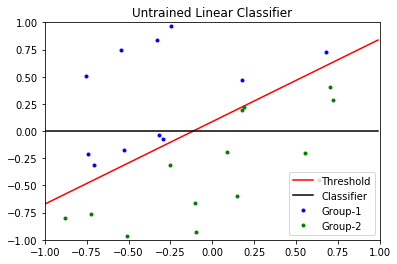

In [4]:
#Create the figure window.
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the points
def plot_points(x_p, y_p, group, w, m, b, title):
    plt.figure()
    plt.title(title)
    plt.xlim([-1,1])
    plt.ylim([-1,1])

    #Plot the target function.
    x_range = np.arange(-1,1,0.01)
    plt.plot(x_range, x_range*m+b, 'r', label="Threshold")
    
    #Plot the predicting dividing line
    m_pred = -w[1]/w[2]
    b_pred = -w[0]/w[2]
    plt.plot(x_range, x_range*m_pred+b_pred, 'k', label="Classifier")
    
    #Plot the input points
    plt.plot(x_p[group==1], y_p[group==1],'b.', label="Group-1")
    plt.plot(x_p[group==-1], y_p[group==-1],'g.', label="Group-2")
    
    #Include a legend
    plt.legend(loc=4)
    return

#Plot an initial guess
plot_points(x_p,y_p,group,[0,0,1], m, b, "Untrained Linear Classifier")

Clearly, the untrained linear classifier doesn't do a good job! Let's use PLA.

Each iteration of the PLA starts by identifying a misclassified point, $x_n$, and then iteratively applies
\begin{equation*}
\vec{w} \rightarrow \vec{w} + g_{i}\vec{x_n}
\end{equation*}
to a misclassified point at random. It is guaranteed to converge for linearly separable datasets.

An implementation of the algorithm is below:

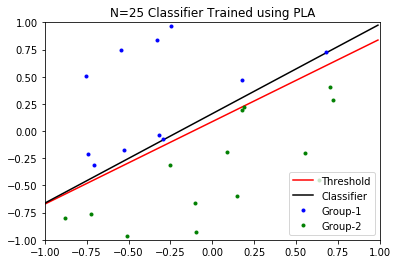

In [5]:
#Apply the Perceptron learning algorithm to a set of points (x_p, y_p)
#Points above/below the threshold are in groups 1/-1 respectively
def pla(x_p, y_p, group):

    #Initial guess for w
    w=[0,0,1]

    #Seed the random number generator for reproducibility.
    np.random.seed(1234)

    #Check classification performance of initial w
    class_group = predict_group(x_p, y_p, w)

    #Iteration counter
    it=0

    #Iteratively apply PLA until all points are correctly classified
    max_it=2000
    while((not np.array_equal(group,class_group)) and it<max_it):
    
        #Count iterations
        it = it + 1

        #Get indices of mislabeled points
        mislabeled = np.where(group!=class_group)[0]

        #Pick a mislabeled point at random
        mis_ind = int(np.floor(np.random.rand() * len(mislabeled)))
        move_ind = mislabeled[mis_ind]
    
        #Update the classifier, w
        w[0] = w[0] + group[move_ind]
        w[1] = w[1] + x_p[move_ind] * group[move_ind]
        w[2] = w[2] + y_p[move_ind] * group[move_ind]

        #Check which points the classifier describes correctly
        class_group = predict_group(x_p, y_p, w)
    
    #Return the classifier and number of iterations
    return it, w

#Run an example with the initial dataset
it, w = pla(x_p, y_p, group)
plot_points(x_p, y_p, group, w, m, b, "N=25 Classifier Trained using PLA")

Now, let's examine the performance of PLA as a function of number of data points, N.

In [6]:
#Generate a set of N points and run the PLA algorithm
def gen_points_and_pla(N, plot):
    
    #Generate a random line
    m, b = gen_line()
    
    #Generate N points in [-1, 1]
    x_p, y_p = gen_points(N)
        
    #Assign groups based on the dividing line
    group = determine_group(x_p, y_p, m, b)
    
    #Train a binary classifier using the PLA
    it, w = pla(x_p, y_p, group)
    
    #Plot the result and print iteration count
    if (plot>0):
        heading = "N=" + str(N)
        plot_points(x_p, y_p, group, w, m, b, heading)
    print("N=" + str(N) + ", Iterations=" + str(it))
    return it, w

Now, let us examine the performance of the PLA for N=10,25,250,500.

N=10, Iterations=3


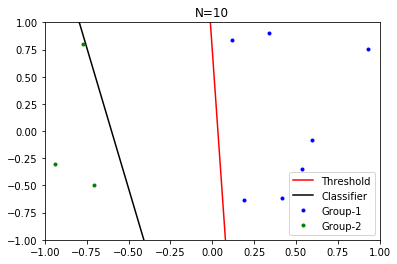

In [7]:
it, w = gen_points_and_pla(10,1)

N=50, Iterations=10


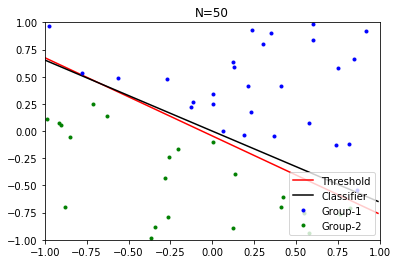

In [8]:
it, w = gen_points_and_pla(50,1)

N=250, Iterations=11


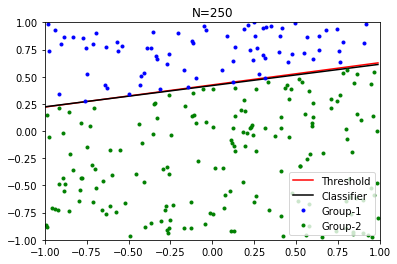

In [9]:
it, w = gen_points_and_pla(250,1)

N=500, Iterations=313


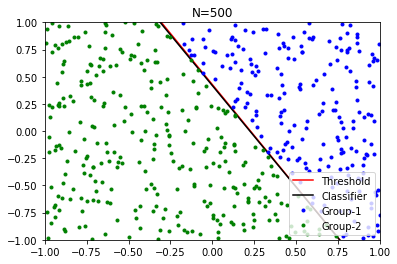

In [10]:
it, w = gen_points_and_pla(500,1)

From this sample, it is clear that the accuracy of the PLA increases with the number of data points, but so does the number of iterations for convergence. When selecting the number of data points, care should be taken to balance the desired levels of speed and accuracy.